In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import os

path_to_project = os.path.abspath(os.path.join(os.getcwd(), '../'))    
sys.path.insert(1, os.path.join(path_to_project))

## 2.1 Warm-up Exercise: Hypothesis Testing & Confounding [6 pts]

Task 2.1.1 [1 pts]. Implement the Log-Rank test from scratch in Python. Using the UNOS dataset, apply
your implemented test to check whether the survival outcomes of patients on ventricular assist device (VAD)
support differ from those of patients without VAD support.

In [ ]:
import pandas as pd
from src.directory import dataset_paths
from src.metrics import log_rank_test

In [ ]:
UNOS_data = pd.read_csv(dataset_paths['unos'])
event_col = "Censor (Censor = 1)"
time_col = "Survival Time"

In [4]:
log_rank_results = log_rank_test(UNOS_data, 
                                event_col="Censor (Censor = 1)", 
                                time_col="Survival Time",
                                group_col="vad_while_listed")
Z, p_value = log_rank_results
Z, p_value

(-8.955531156690666, 0.005532614903659416)

Task 2.1.2 [1 pts]. Propose a method to determine if there are confounders in the UNOS dataset for the ef-
fect of VAD support on survival outcomes. List all detected confounders.

In [5]:
from src.data_dict import feature_config
from src.utils import test_unconfoundedness_by_feature

In [6]:
vad_col = "vad_while_listed"
feature_cols = list(set(feature_config['unos']) - set([vad_col]))

In [7]:
# test unconfoundedness/conditional ignorability
confounders = test_unconfoundedness_by_feature(UNOS_data, 
                                               outcome_col=time_col,
                                               conditional_col=vad_col,
                                               feature_cols=feature_cols)
confounders

,corr,p_value,confounder
feature,,,
init_bmi_calc,0.231843,0.0,True
gender,-0.037045,0.005622,True
abo_A,0.048125,0.000321,True
inotropic,0.150174,0.0,True
ventilator_tcr,0.258398,0.0,True
hgt_cm_tcr,0.161952,0.0,True
init_age,0.132576,0.0,True
abo_B,0.058546,0.000012,True
diab,0.036893,0.005821,True


Task 2.1.3 [2 pts]. For the comparison of survival curves to have a causal interpretation, we need to adjust
for confounding variables that may cause the patient groups being compared to have different clinical features. Propose a propensity-weighted version of the Kaplan-Meier estimator you implemented in Project 1 that ad-
justs for confounding. Plot the propensity-weighted Kaplan-Meier curves in patients with and without VAD.
Compare this plot with the survival curves of both groups using the standard Kaplan-Meier estimators.

In [ ]:
from copy import deepcopy
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns
from src.estimators import kaplan_meier
from src.utils import get_propensity_scores


In [9]:
# get propensity scores
propensity_col = 'propensity_vad'
propensity_score = get_propensity_scores(UNOS_data, T_col=vad_col, X_cols=feature_cols)
propensity_df = deepcopy(UNOS_data)
propensity_df[propensity_col] = propensity_score

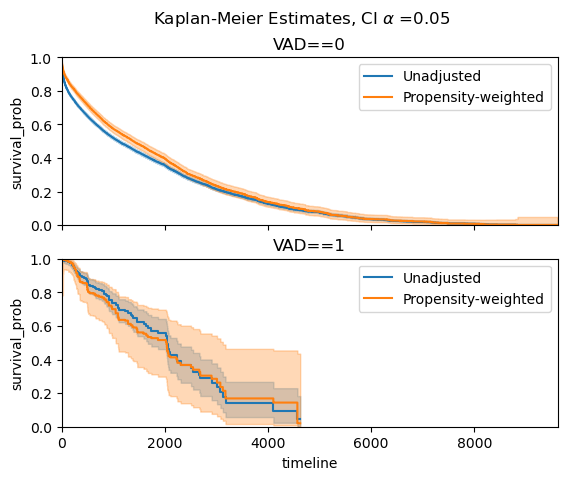

In [10]:
# set CI alpha
alpha = 0.05

# create figure
nrows = 2
fig, axs = plt.subplots(nrows=nrows, sharex=True)
axs = axs.ravel()
colors = sns.color_palette()

for i, group in enumerate([0,1]):
    ax = axs[i]

    # get group data
    group_data = propensity_df.query(f'{vad_col}=={group}')

    # plot lifelines KM
    kmf = KaplanMeierFitter(alpha=alpha)
    kmf.fit(group_data[time_col], event_observed=group_data[event_col])
    kmf.plot_survival_function(label=f'Unadjusted', ax=ax, c=colors[0])

    # get propensity-weighted KM estimate from scratch
    km_df = kaplan_meier(group_data, time_col, event_col, 
                         propensity_col=propensity_col, 
                         alpha=alpha)
    sns.lineplot(data=km_df, x='time', y='survival_prob',
                 drawstyle='steps-pre', ax=ax, label='Propensity-weighted', legend=True, c=colors[1])
    ax.fill_between(km_df['time'], km_df['ci_lower'], km_df['ci_upper'], alpha=0.3, color=colors[1])

    ax.set_title(f'VAD=={group}')
    ax.set_ylim([0, 1])
    ax.set_xlim([0, UNOS_data[time_col].max()])

plt.suptitle(fr'Kaplan-Meier Estimates, CI $\alpha$ ={alpha}')
plt.show()

Task 2.1.4 [2 pts]. Propose a propensity-weighted version of the Long-Rank test. Apply this test to check
whether the survival outcomes of patients on VAD support differ from those of patients without VAD. Com-
pare the result of this test with the unadjusted test you implemented in Task 2.1.1. Comment on the results.

In [11]:
log_rank_results = log_rank_test(propensity_df,
                                event_col="Censor (Censor = 1)", 
                                time_col="Survival Time",
                                group_col="vad_while_listed",
                                propensity_col=propensity_col)
Z, p_value = log_rank_results
Z, p_value

(-1.134692377210382, 0.5735533100601058)

## 2.2 ML-based Estimation of Average Treatment Effects [6 pts]

Estimate the average effect of aspirin and heparin on 14-day mortality using the following estimators. Com-
pare your estimates with those of the original trial and provide commentary on the results

Task 2.2.1 [1 pts]. A standard difference-in-means estimator.<br />
Task 2.2.2 [1 pts]. An inverse propensity weighting (IPW) estimator using a Gradient Boosting model for
the propensity scores.<br />
Task 2.2.3 [2 pts]. A covariate adjustment estimator using a Gradient Boosting model with T-learner, S-
learner, and X-learner architectures.<br />
Task 2.2.4 [2 pts]. An augmented IPW (doubly-robust) estimator that combines the propensity model from
Task 2.2.2 and an outcomes model based on the S-learner in Task 2.2.3.

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import os

path_to_project = os.path.abspath(os.path.join(os.getcwd(), '../'))    
sys.path.insert(1, os.path.join(path_to_project))

In [ ]:
from itertools import product
import pandas as pd
from src.directory import dataset_paths
from src.data_dict import feature_config
from src.utils import preprocess_ist
from src.estimators import unadjusted_DM_estimator, ipw_estimator, t_learner, s_learner, x_learner, aipw_estimator

In [3]:
# event censoring
event_col = 'SET14D'

# time to event
time_col = 'TD'

# outcomes 
mortality14_col = 'ID14'

# predictions
exp_mortality14_col = 'EXPD14'

# treatments
asp_col = 'DASP14'
low_dose_hep_col = 'DLH14'
med_dose_hep_cols = ['DMH14', 'DHH14']
heparin_cols = [low_dose_hep_col, *med_dose_hep_cols]
combined_hep_col = 'DH14'

# features
ist_feature_cols = feature_config['ist']

# columns to read in
select_ist_cols = [event_col, time_col, mortality14_col, exp_mortality14_col, asp_col, *heparin_cols, *ist_feature_cols]

# columns not to transform
untransformed_cols = [x for x in select_ist_cols if x in [event_col, time_col, mortality14_col, exp_mortality14_col, asp_col]]

In [4]:
# read in data
ist_corrected = pd.read_csv(dataset_paths['ist_corrected'], sep='\t', encoding='utf-16', usecols=select_ist_cols) # corrected
ist_original = pd.read_csv(dataset_paths['ist_original'], usecols=select_ist_cols) # observational

/tmp/ipykernel_526798/892560532.py:2: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  ist_corrected = pd.read_csv(dataset_paths['ist_corrected'], sep='\t', encoding='utf-16', usecols=select_ist_cols) # corrected


In [5]:
ist_corrected, covariates = preprocess_ist(ist_corrected, 
                                           feature_cols=ist_feature_cols,
                                           untransformed_cols=untransformed_cols,
                                           heparin_cols=heparin_cols,
                                           combined_hep_col=combined_hep_col)
ist_corrected.name = 'ist_corrected'

ist_original, _ = preprocess_ist(ist_original, 
                                feature_cols=ist_feature_cols,
                                untransformed_cols=untransformed_cols,
                                heparin_cols=heparin_cols,
                                combined_hep_col=combined_hep_col)
ist_original.name = 'ist_original'

/home/hentipapai/PycharmProjects/cph-200b/src/utils.py:141: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace({'Y':1, 'y':1, 'N':0, 'n':0, 'C':float('nan'), 'U': float('nan')})
/home/hentipapai/PycharmProjects/cph-200b/src/utils.py:141: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace({'Y':1, 'y':1, 'N':0, 'n':0, 'C':float('nan'), 'U': float('nan')})


In [6]:
# set up results dataframe
estimators = [unadjusted_DM_estimator, ipw_estimator, t_learner, s_learner, x_learner, aipw_estimator]
ist_datasets = [ist_original, ist_corrected]

estimator_names = [x.__name__ for x in estimators]
dataset_names = [x.name for x in ist_datasets]

index = pd.MultiIndex.from_product([dataset_names, estimator_names], names=['dataset', 'estimator'])
tau_results = pd.DataFrame(index=index, columns=[asp_col, combined_hep_col])

In [7]:
for data, tau_estimator, treatment in product(ist_datasets, estimators, [asp_col, combined_hep_col]):
    estimator_name = tau_estimator.__name__
    dataset_name = data.name
    treatment_observed = ~data[treatment].isna()
    tau = tau_estimator(data[treatment_observed], treatment_var=treatment, outcome_var=mortality14_col, covariates=covariates)
    tau_results.loc[(dataset_name, estimator_name), treatment] = tau
    print(f"{dataset_name} {estimator_name}, avg. effect for {treatment}: {tau}")

ist_original unadjusted_DM_estimator, avg. effect for DASP14: -0.03498893363044499
ist_original unadjusted_DM_estimator, avg. effect for DH14: -0.0033441506096889423
ist_original ipw_estimator, avg. effect for DASP14: -0.013505366708275379
ist_original ipw_estimator, avg. effect for DH14: -0.002651827430883226
ist_original t_learner, avg. effect for DASP14: 0.010928961748633878
ist_original t_learner, avg. effect for DH14: 0.004198152812762382
ist_original s_learner, avg. effect for DASP14: -0.0014712063892391748
ist_original s_learner, avg. effect for DH14: 0.0
ist_original x_learner, avg. effect for DASP14: 0.0440041463522333
ist_original x_learner, avg. effect for DH14: 0.007708126557640407
ist_original aipw_estimator, avg. effect for DASP14: 0.17582557228895285
ist_original aipw_estimator, avg. effect for DH14: 0.18349423595978082
ist_corrected unadjusted_DM_estimator, avg. effect for DASP14: -0.012013646271336456
ist_corrected unadjusted_DM_estimator, avg. effect for DH14: -0.0051

In [8]:
tau_results

DASP14      DH14
dataset       estimator                                  
ist_original  unadjusted_DM_estimator -0.034989 -0.003344
              ipw_estimator           -0.013505 -0.002652
              t_learner                0.010929  0.004198
              s_learner               -0.001471       0.0
              x_learner                0.044004  0.007708
              aipw_estimator           0.175826  0.183494
ist_corrected unadjusted_DM_estimator -0.012014 -0.005129
              ipw_estimator           -0.009397 -0.003817
              t_learner               -0.000928 -0.003036
              s_learner                -0.00165 -0.000412
              x_learner                0.001135  0.004917
              aipw_estimator           0.154144  0.157076

In [10]:
# get difference of estimates
diff_in_estimates = tau_results.query('dataset=="ist_original"').droplevel('dataset') \
    - tau_results.query('dataset=="ist_corrected"').droplevel('dataset')

diff_in_estimates

,DASP14,DH14
estimator,,
unadjusted_DM_estimator,-0.022975,0.001785
ipw_estimator,-0.004108,0.001165
t_learner,0.011857,0.007234
s_learner,0.000178,0.000412
x_learner,0.04287,0.002791
aipw_estimator,0.021682,0.026418
